In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button

TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

## 1)

Przygotuj procedurę, pozwalającą wprowadzać w sposób interaktywny kolejne odcinki (reprezentowane przez pary wierzchołków), a także generować losowo zadaną liczbę odcinków z podanego zakresu współrzędnych 2D. Odcinki pionowe powinny być eliminowane i żadna para odcinków nie powinna mieć końców odcinków o tej samej współrzędnej x. Program powinien umożliwiać zapis i odczyt zbioru odcinków.

In [3]:
def get_lines_from_plot(plot : Plot):
    result = []
    tmp = plot.scenes[0].lines[0].lines
    for all_lines in tmp:
        for line in all_lines:
            result.append((line[0],line[1]))
    return result

In [4]:
def generate_random_lines(quantity, x_begin,x_end,y_begin,y_end):
    lines = []
    X = set()
    for _ in range(quantity):
        point_1 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
        point_2 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
        while (point_1[0]==point_2[0] or point_1[0] in X or point_2[0] in X):
            point_1 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
            point_2 = (random.uniform(x_begin,x_end),random.uniform(y_begin,y_end))
        lines.append((point_1,point_2))
    return lines

In [5]:
def save_to_file(file_name, lines):
    with open(f"{file_name}.json", "w") as f:
        f.write(str(lines))
        
def load_from_file(file_name):
    with open(f"{file_name}.json", "r") as f:
        data = f.readlines()
    return data

<IPython.core.display.Javascript object>


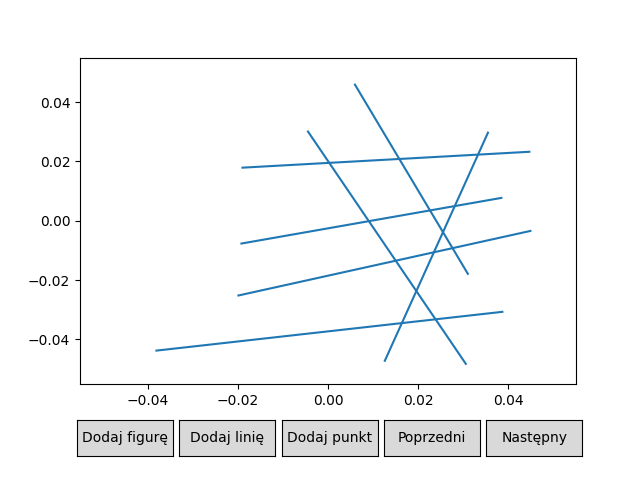

In [6]:
plot = Plot(scenes=[Scene()])
plot.draw()


In [7]:
L = generate_random_lines(5,-10,10,-10,10)

<IPython.core.display.Javascript object>


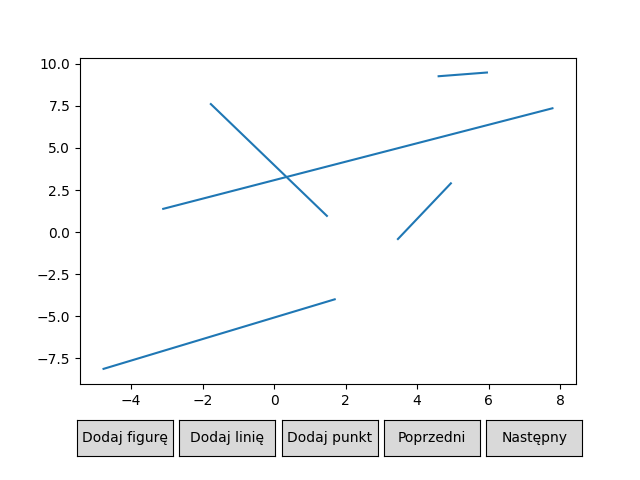

In [8]:
plot = Plot([Scene(lines=[LinesCollection(L)])])
plot.draw()

In [9]:
save_to_file("linie",get_lines_from_plot(plot))

In [10]:
plot.scenes[0].lines[0].lines

[((1.72239598211611, -3.9734748371881405),
  (-4.800478093890284, -8.141454519699394)),
 ((7.81342542228127, 7.375158989025405),
  (-3.1313614297194032, 1.3692665394277377)),
 ((5.981707064300588, 9.48951111592833),
  (4.5722366661401885, 9.258923038567588)),
 ((-1.792058749426996, 7.652552937267135),
  (1.4964974195668113, 0.9230035827645882)),
 ((4.9639385131506515, 2.944853244572725),
  (3.4426632130342565, -0.4540158751732175))]

In [11]:
https://www.pythontutorial.net/python-basics/python-write-csv-file/get_lines_from_plot(Plot([Scene(lines=[LinesCollection(L)])]))

[(1.72239598211611, -3.9734748371881405),
 (-4.800478093890284, -8.141454519699394),
 (7.81342542228127, 7.375158989025405),
 (-3.1313614297194032, 1.3692665394277377),
 (5.981707064300588, 9.48951111592833),
 (4.5722366661401885, 9.258923038567588),
 (-1.792058749426996, 7.652552937267135),
 (1.4964974195668113, 0.9230035827645882),
 (4.9639385131506515, 2.944853244572725),
 (3.4426632130342565, -0.4540158751732175)]

In [12]:
plotek = load_from_file("linie")

In [104]:
plotek

['[(6.9764460011740645, 8.196690142454806), (-7.577609384037416, 3.4088604776546525), (-4.974828023430309, -9.959573628938529), (7.724047160176635, -3.7104836165352832), (-9.025545396106736, -7.467287069514459), (8.715157512618529, -3.89293204236401), (-3.101489969091336, 6.776268825776874), (1.6548926456817998, -7.148638552784618), (-5.229431173200288, -5.803715700166019), (1.6713476511183032, 8.870175051273645)]']